In [ ]:
import ray
from time import time
from matplotlib import pyplot as plt

from Quantum_functions import *
from QuantumPFunctions import *

In [2]:
gb = 1024*1024*1024

from qutip import *
# Start Ray.
ray.init()
#ray.init(memory =14*gb, object_store_memory = 12*gb)

2020-03-27 23:03:30,555	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-03-27 23:03:30,557	INFO resource_spec.py:212 -- Starting Ray with 8.25 GiB memory available for workers and up to 4.14 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-03-27 23:03:30,871	INFO services.py:1078 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '192.168.1.97',
 'redis_address': '192.168.1.97:48486',
 'object_store_address': '/tmp/ray/session_2020-03-27_23-03-30_554989_15664/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-03-27_23-03-30_554989_15664/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-03-27_23-03-30_554989_15664'}

In [11]:
n = 10
processors = 4
state1 = tensor([basis(2,0)]*n)

alpha1 = Heisenberg1dRingGen(1,1,1,n)
alpha0 = lambda n,m,i,j: 0
beta1 = lambda n,i : [0,0,1][i]
beta0 = lambda n,i :0

self_interaction = hamiltonian(alpha1,beta0,n)
self_interaction = self_interaction/self_interaction.norm()
external_interaction = hamiltonian(alpha0,beta1,n)
external_interaction = external_interaction/external_interaction.norm()


perturbation: Qobj = make_hermitian(rand_unitary(2**n, dims = self_interaction.dims))
perturbation = perturbation/perturbation.norm()
epsilon = 0.3

H1 = epsilon*self_interaction + external_interaction + epsilon**2*perturbation
H2 = external_interaction
H3 = external_interaction + epsilon*perturbation

262144it [13:06, 333.20it/s]


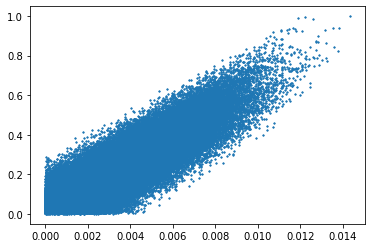

Finished executing completed in 790.5172624588013s


In [9]:
start = time()
xs,ys = energy_trace_comp_2d(H1,1,1)
end = time()

single_t = end-start

plt.scatter(xs,ys,s=1)
plt.show()
print(f"Finished executing completed in {end-start}s")

In [12]:
start = time()
xs,ys = energy_trace_compare_p(H1,1,1,proc =processors)
end = time()

mulit_t  = end-start
print(len(xs))

plt.scatter(xs,ys,s=1)
plt.show()

print(f"Finished executing completed in {end-start}s")


Starting3


2020-03-27 23:32:30,935	WARNING worker.py:274 -- Waiting 1 seconds for space to free up in the object store.
2020-03-27 23:32:34,172	WARNING worker.py:274 -- Waiting 2 seconds for space to free up in the object store.
2020-03-27 23:32:36,218	WARNING worker.py:274 -- Waiting 4 seconds for space to free up in the object store.
2020-03-27 23:32:40,268	WARNING worker.py:274 -- Waiting 8 seconds for space to free up in the object store.
2020-03-27 23:32:48,329	WARNING worker.py:274 -- Local object store memory usage:
num clients with quota: 0
quota map size: 0
pinned quota map size: 0
allocated bytes: 0
allocation limit: 4441517260
pinned bytes: 154
(global lru) capacity: 4441517260
(global lru) used: 0%
(global lru) num objects: 0
(global lru) num evictions: 10
(global lru) bytes evicted: 3030625978

2020-03-27 23:32:48,331	INFO worker.py:1541 -- Put failed since the value was either too large or the store was full of pinned objects. If you are putting and holding references to a lot of ob

ObjectStoreFullError: Failed to put object ffffffffffffffffffffffff0100008007000000 in object store because it is full. Object size is 21479383406 bytes.

In [10]:
print(f"System obtains a speedup of {single_t/mulit_t} using {processors} processors" )

System obtains a speedup of 1.4853616043938034 using 4 processors
